# Подбор модели и признаков

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, normal_ad
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv('cars_clean_clean')
df

,Unnamed: 0.1,Unnamed: 0,brand,color,color_group,gearbox,drive,fuel_type,city,city_group,...,power_2,model_popularity,age,generation,is_new,is_restyling,is_pro,is_max,is_premium,price
0,0,0,Haval,серый,Нейтральные,робот,полный,Бензин,Москва,Москва,...,177.0,4.0,1.0,1,False,0,0,0,0,2320000.0
1,1,1,Chery,серый,Нейтральные,механика,передний,Бензин,Москва,Москва,...,113.0,270.0,1.0,1,False,0,1,0,0,1490000.0
2,2,2,Haval,чёрный,Нейтральные,робот,полный,Бензин,Москва,Москва,...,177.0,4.0,1.0,1,False,0,0,0,0,2650000.0
3,3,3,Geely,синий,Холодные,робот,передний,Бензин,Балашиха,Московская область,...,200.0,7.0,2.0,1,False,1,0,0,0,2980000.0
4,4,4,Chery,серый,Нейтральные,робот,передний,Бензин,Москва,Москва,...,147.0,270.0,3.0,1,False,1,0,0,0,1500000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,1310,1310,Geely,серебристый,Нейтральные,автомат,полный,Бензин,Москва,Москва,...,238.0,319.0,0.0,1,False,1,0,0,1,3830000.0
1311,1311,1311,Geely,голубой,Холодные,робот,передний,Бензин,Москва,Москва,...,181.0,80.0,1.0,1,False,0,0,0,0,2699999.0
1312,1312,1312,Geely,серый,Нейтральные,робот,передний,Бензин,Москва,Москва,...,181.0,80.0,1.0,1,False,0,0,0,0,2699999.0
1313,1313,1313,Geely,синий,Холодные,робот,полный,Бензин,Одинцово,Московская область,...,177.0,132.0,3.0,1,False,0,1,0,0,2100000.0


In [2]:
target = 'price'
numeric_feats = ['mileage', 'power_1', 'power_2', 'age']
cat_feats = ['brand', 'color_group', 'gearbox', 'drive', 'fuel_type', 'city_group', 'car_class']
dummies = ['is_restyling', 'is_pro', 'is_max', 'is_premium']

In [3]:
custom_palette = sns.color_palette([
    '#E83D84', '#FF8FAB', '#FFB3C6',  # Розовые оттенки
    '#F5F5F5',                       # Нейтральный
    '#C8E6C9', '#A5D6A7', '#81C784'  # Мятные оттенки
])

Убираем переменные, которые оказались довольно бесполезны на этапе анализа ('generation', 'is_new', 'model_popularity'), а также категориальные переменные с большим количество уникальных значений ('city', 'color', 'base_model'; их мы заменяем на переменные 'color_group', 'city_group', 'brand' и др. где меньше категорий)

In [5]:
removed = ['generation', 'is_new', 'model_popularity', 'city', 'color', 'base_model']

Создадим дамми-переменные для категориальных признаков (при этом не забудем удалить одну из категорий, чтобы не было чистой мультиколленеарности с константой модели)

In [9]:
def prepare_data(df, target_col, categorical_cols, numeric_cols=None, dummies=None):
    """Подготовка данных с обработкой категориальных и числовых признаков"""
    # Создание dummy-переменных
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded = encoder.fit_transform(df[categorical_cols])
    encoded_df = pd.DataFrame(encoded, 
                            columns=encoder.get_feature_names_out(categorical_cols))
    
    # Обработка числовых признаков
    if numeric_cols is None:
        numeric_cols = df.drop(columns=[target_col] + categorical_cols).columns
    
    X_numeric = df[numeric_cols].copy()
    X_dum = df[dummies].copy()
    
    # Создание преобразованных признаков
    X_transformed = pd.DataFrame()
    for col in numeric_cols:
        X_transformed[f'log_{col}'] = np.log1p(X_numeric[col])
        X_transformed[f'sq_{col}'] = X_numeric[col]**2
    
    # Объединение всех признаков
    X = pd.concat([X_numeric, X_transformed, encoded_df, X_dum], axis=1)
    y = df[target_col]
    
    return X, y, np.log1p(y), encoder

In [10]:
# Подготовка данных
X_full, y, log_y, encoder = prepare_data(df, target, cat_feats, numeric_feats, dummies)

In [11]:
X_full

,mileage,power_1,power_2,age,log_mileage,sq_mileage,log_power_1,sq_power_1,log_power_2,sq_power_2,...,city_group_Прочие города,car_class_Crossover,car_class_Luxury SUV,car_class_Other,car_class_SUV,car_class_Sedan,is_restyling,is_pro,is_max,is_premium
0,12000.0,1.5,177.0,1.0,9.392745,1.440000e+08,0.916291,2.25,5.181784,31329.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0
1,52460.0,1.5,113.0,1.0,10.867825,2.752052e+09,0.916291,2.25,4.736198,12769.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0,1,0,0
2,6308.0,1.5,177.0,1.0,8.749732,3.979086e+07,0.916291,2.25,5.181784,31329.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0
3,17169.0,2.0,200.0,2.0,9.750919,2.947746e+08,1.098612,4.00,5.303305,40000.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0
4,22000.0,1.5,147.0,3.0,9.998843,4.840000e+08,0.916291,2.25,4.997212,21609.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,10.0,2.0,238.0,0.0,2.397895,1.000000e+02,1.098612,4.00,5.476464,56644.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0,1
1311,1.0,1.5,181.0,1.0,0.693147,1.000000e+00,0.916291,2.25,5.204007,32761.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0
1312,10.0,1.5,181.0,1.0,2.397895,1.000000e+02,0.916291,2.25,5.204007,32761.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0
1313,58000.0,1.5,177.0,3.0,10.968216,3.364000e+09,0.916291,2.25,5.181784,31329.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0


In [12]:
y

0       2320000.0
1       1490000.0
2       2650000.0
3       2980000.0
4       1500000.0
          ...    
1310    3830000.0
1311    2699999.0
1312    2699999.0
1313    2100000.0
1314    3750000.0
Name: price, Length: 1315, dtype: float64

In [13]:
num_feats = ['mileage', 'power_1', 'power_2', 'age']

log_feats = ['log_mileage', 'log_power_1', 'log_power_2', 'log_age']

sq_feats = ['sq_mileage', 'sq_power_1', 'sq_power_2', 'sq_age']

dummy = ['brand_Geely', 'brand_Haval', 'color_group_Тёплые',
       'color_group_Холодные', 'color_group_Экзотические', 'gearbox_вариатор',
       'gearbox_механика', 'gearbox_робот', 'drive_полный', 'fuel_type_Гибрид',
       'fuel_type_Дизель', 'city_group_Города-спутники', 'city_group_Москва',
       'city_group_Московская область', 'city_group_Прочие города',
       'car_class_Crossover', 'car_class_Luxury SUV', 'car_class_Other',
       'car_class_SUV', 'car_class_Sedan']

dummy_original = ['is_restyling', 'is_pro', 'is_max', 'is_premium']

# Линейная модель

In [119]:
X = sm.add_constant(X_full[num_feats + dummy + dummy_original])
model_linear_base = sm.OLS(y, X).fit()

print(model_linear_base.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     549.3
Date:                Sun, 27 Apr 2025   Prob (F-statistic):               0.00
Time:                        13:57:46   Log-Likelihood:                -18328.
No. Observations:                1315   AIC:                         3.671e+04
Df Residuals:                    1286   BIC:                         3.686e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

#### Интерпретация результатов регрессии

**Общая характеристика модели**
- **R² = 0.923**: Модель объясняет 92.3% вариации цен на автомобили (очень высокий показатель)
- **F-статистика = 549.3 (p=0.00)**: Модель в целом статистически значима
- **Наблюдения**: 1,315 автомобилей

**Ключевые драйверы цены**

1. Основные числовые факторы
| Фактор       | Коэффициент | Влияние на цену (+1 единица) | Экономический смысл |
|--------------|-------------|-----------------------------|---------------------|
| **Пробег**   | -7.13       | ▼ 7.1 рубля за км           | Каждый км пробега снижает цену |
| **Мощность** | 4,305.58    | ▲ 4,306 руб за л.с.         | Мощные двигатели значительно дороже |
| **Возраст**  | -34,680     | ▼ 34,680 руб за год         | Новые авто ценятся существенно выше |

2. Бренды (база: Chery?)
| Бренд  | Премия к цене | Значимость |
|--------|---------------|------------|
| Geely  | +166,500 руб  | Значимо    |
| Haval  | +225,300 руб  | Значимо    |

3. Цвета (парадоксальные результаты)
- **Теплые цвета**: - 319,000 руб (сильно снижают цену)
- **Холодные**: + 250,600 руб 
- **Экзотические**: - 657,200 руб 

4. Технические характеристики
| Характеристика          | Эффект          | Комментарий |
|-------------------------|-----------------|-------------|
| Полный привод          | + 268,200 руб   | Значимый плюс |
| Дизельный двигатель    | + 1.02 млн руб  | Максимальная премия |
| Автоматическая КПП     | (база)          | -           |
| Механика               | + 266,600 руб   | Существенный плюс|


5. **Премиальные флаги снижают цену**:
   - `is_pro`: - 115,300 руб
   - `is_max`: - 257,000 руб
   - `is_premium`: + 498,500 руб

6. **Рестайлинг**: + 365,300 руб

**Проблемы модели**

1. **Мультиколлинеарность**:
   - Cond. No. = 4.51e+06 (крайне высокое)

2. **Ненормальность остатков**:
   - JB-test p-value = 3.8e-37
   - Асимметрия и эксцесс (Skew=0.08, Kurtosis=4.74)

Попорбуем удалить сильно скоррелированные признаки и использовать робастные ошибки

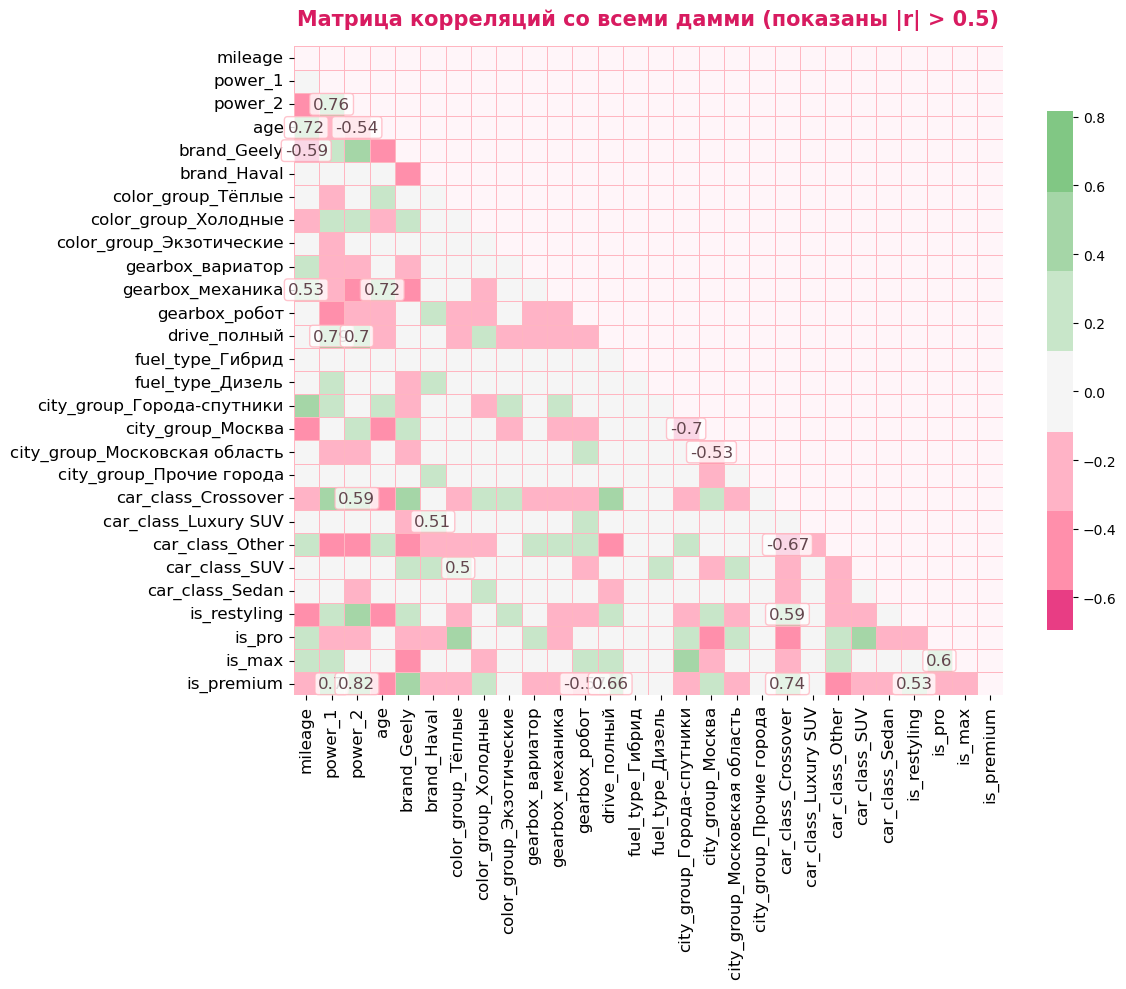

In [120]:
# Выбираем признаки для анализа
corr_features = num_feats + dummy + dummy_original

# Создаем фигуру
plt.figure(figsize=(12, 10))

# Вычисляем корреляционную матрицу
corr = X_full[corr_features].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Создаем маску для аннотаций (показываем только |corr| > 0.5)
annot_mask = (np.abs(corr) > 0.5) & ~mask
annot_values = np.where(annot_mask, corr.round(2), '')

# Строим тепловую карту
heatmap = sns.heatmap(
    corr, 
    mask=mask,
    annot=annot_values,  # Используем отфильтрованные аннотации
    fmt='',             # Уже отформатированные значения
    cmap=custom_palette,
    center=0,
    linewidths=0.5,
    linecolor='#FFB6C1',
    cbar_kws={'shrink': 0.8},
    annot_kws={
        'fontsize': 12,
        'color': '#63464D',
        'bbox': dict(boxstyle='round,pad=0.2',
                    facecolor='white',
                    edgecolor='#FFB6C1',
                    alpha=0.8)
    }
)

# Стилизация
heatmap.set_facecolor('#FFF5F9')

for spine in heatmap.spines.values():
    spine.set_color('#FFB6C1')
    spine.set_linewidth(2)

plt.title('Матрица корреляций cо всеми дамми (показаны |r| > 0.5)', 
         fontsize=15, pad=15,
         color='#D81B60',
         weight='bold')

plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [139]:
# убираем сильно скоррелированные признаки
correlated_removed = ['age', 'brand_Geely', 'power_1', 'is_premium', 'drive_полный', 
                      'car_class_Luxury SUV', 'car_class_SUV', 'city_group_Города-спутники', 
                      'city_group_Московская область', 'car_class_Other', 'is_pro']

In [141]:
X_1 = sm.add_constant(X_cleaned)
model_linear_1 = sm.OLS(y, X_1).fit(cov_type='HC3')  
print(model_linear_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     655.4
Date:                Sun, 27 Apr 2025   Prob (F-statistic):               0.00
Time:                        14:11:31   Log-Likelihood:                -18473.
No. Observations:                1315   AIC:                         3.698e+04
Df Residuals:                    1297   BIC:                         3.708e+04
Df Model:                          17                                         
Covariance Type:                  HC3                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

Все еще есть мультиколленеарность, хоть она и уменьшилась

In [16]:
def check_assumptions(model, X, y):
    """Проверка предпосылок классической линейной регрессии"""
    # Нормальность остатков
    _, p_norm = normal_ad(model.resid)
    print(f"Тест на нормальность (p-value): {p_norm:.4f}")
    
    # Мультиколлинеарность
    vif = pd.DataFrame()
    vif['Variable'] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print("\nVIF факторов:")
    return vif.sort_values("VIF", ascending=False)

In [143]:
check_assumptions(model_linear_base, X, y)

Тест на нормальность (p-value): 0.0000

VIF факторов:


,Variable,VIF
0,const,1784.899647
22,car_class_Other,345.434579
20,car_class_Crossover,329.074668
23,car_class_SUV,151.446934
24,car_class_Sedan,75.645970
21,car_class_Luxury SUV,29.642918
28,is_premium,16.526438
17,city_group_Москва,11.416393
3,power_2,10.528839
13,drive_полный,7.996251


In [144]:
check_assumptions(model_linear_1, X_1, y)

Тест на нормальность (p-value): 0.0000

VIF факторов:


,Variable,VIF
0,const,116.200926
10,power_2,3.477538
6,gearbox_механика,3.244890
12,gearbox_робот,3.045979
9,mileage,2.559075
5,car_class_Crossover,2.418661
15,gearbox_вариатор,2.387019
13,is_restyling,1.963302
2,city_group_Москва,1.660070
14,is_max,1.479639


Заметим, что высокий VIF не у регрессоров, а у константы модели.

In [147]:
feats_approved = X_cleaned.columns

Теперь попробуем убрать признаки, которые оказались незначимы на уровне значимости 10%

In [207]:
not_imp = ['brand_Haval',
'car_class_Sedan',
'car_class_Crossover',
'city_group_Прочие города']

feats_approved_2 = list(set(feats_approved.to_list()) - set(not_imp))

X_4 = sm.add_constant(X_cleaned[feats_approved_2])
model_linear_3 = sm.OLS(y, X_4).fit()  
print(model_linear_3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     934.0
Date:                Sun, 27 Apr 2025   Prob (F-statistic):               0.00
Time:                        14:53:23   Log-Likelihood:                -18477.
No. Observations:                1315   AIC:                         3.698e+04
Df Residuals:                    1301   BIC:                         3.706e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [208]:
check_assumptions(model_linear_3, X_4, y)

Тест на нормальность (p-value): 0.0000

VIF факторов:


,Variable,VIF
0,const,96.594990
8,power_2,2.848007
3,gearbox_механика,2.844493
9,gearbox_робот,2.712513
6,mileage,2.383501
12,gearbox_вариатор,2.076818
10,is_restyling,1.628521
2,city_group_Москва,1.575694
11,is_max,1.333925
4,color_group_Тёплые,1.303678


In [230]:
# Пробуем убрать power_2 чтобы уменьшить VIF
feats_vif_check = ['fuel_type_Дизель',
                 'city_group_Москва',
                 'gearbox_механика',
                 'color_group_Тёплые',
                 'color_group_Холодные',
                 'mileage',
                 'color_group_Экзотические',
                 #'power_2',
                 'gearbox_робот',
                 'is_restyling',
                 'is_max',
                 'gearbox_вариатор',
                 'fuel_type_Гибрид']
X_5 = sm.add_constant(X_full[feats_vif_check])
model_linear_4 = sm.OLS(y, X_5).fit()  
print(model_linear_4.summary())
check_assumptions(model_linear_4, X_5, y)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     536.2
Date:                Sun, 27 Apr 2025   Prob (F-statistic):               0.00
Time:                        16:38:55   Log-Likelihood:                -18841.
No. Observations:                1315   AIC:                         3.771e+04
Df Residuals:                    1302   BIC:                         3.778e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Variable,VIF
0,const,14.080668
6,mileage,2.382366
3,gearbox_механика,2.014902
8,gearbox_робот,1.662068
2,city_group_Москва,1.575116
9,is_restyling,1.510992
10,is_max,1.330395
11,gearbox_вариатор,1.272715
4,color_group_Тёплые,1.221867
5,color_group_Холодные,1.154629


In [231]:
# Убираем незначимые признаки
feats_vif_check = ['fuel_type_Дизель',
                 'city_group_Москва',
                 'gearbox_механика',
                 'color_group_Тёплые',
                 'color_group_Холодные',
                 'mileage',
                 'color_group_Экзотические',
                 #'power_2',
                 'gearbox_робот',
                 'is_restyling',
                 #'is_max',
                 'gearbox_вариатор']
                 #'fuel_type_Гибрид']
X_5 = sm.add_constant(X_full[feats_vif_check])
model_linear_4 = sm.OLS(y, X_5).fit()  
print(model_linear_4.summary())
check_assumptions(model_linear_4, X_5, y)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     644.0
Date:                Sun, 27 Apr 2025   Prob (F-statistic):               0.00
Time:                        16:39:57   Log-Likelihood:                -18841.
No. Observations:                1315   AIC:                         3.770e+04
Df Residuals:                    1304   BIC:                         3.776e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

,Variable,VIF
0,const,13.905194
6,mileage,2.131166
3,gearbox_механика,1.920081
8,gearbox_робот,1.575080
2,city_group_Москва,1.558404
9,is_restyling,1.459154
10,gearbox_вариатор,1.255588
4,color_group_Тёплые,1.214536
5,color_group_Холодные,1.136796
7,color_group_Экзотические,1.133718


In [148]:
#Удалим лишь те признаки, у которых высокий VIF в базовой модели

res = check_assumptions(model_linear_base, X, y)
feats_bad = (res[res['VIF'] > 5]['Variable'][1:]).to_list()

X_cleaned_2 = X_full[num_feats + dummy + dummy_original][list(set(X_full[num_feats + dummy + dummy_original].columns) - set(feats_bad))]
X_cleaned_2 

X_2 = sm.add_constant(X_cleaned_2)
model_linear_2 = sm.OLS(y, X_2).fit(cov_type='HC3')  
print(model_linear_2.summary())

check_assumptions(model_linear_2, X_2, y)

Тест на нормальность (p-value): 0.0000

VIF факторов:
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     269.9
Date:                Sun, 27 Apr 2025   Prob (F-statistic):          4.21e-309
Time:                        14:12:37   Log-Likelihood:                -19225.
No. Observations:                1315   AIC:                         3.847e+04
Df Residuals:                    1304   BIC:                         3.853e+04
Df Model:                          10                                         
Covariance Type:                  HC3                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------

,Variable,VIF
0,const,3.623880
7,is_restyling,1.264053
5,mileage,1.244529
2,brand_Haval,1.161914
1,fuel_type_Дизель,1.103284
3,color_group_Тёплые,1.070420
8,gearbox_вариатор,1.070203
4,color_group_Холодные,1.060197
6,color_group_Экзотические,1.028629
9,city_group_Прочие города,1.028069


1. Общие показатели модели
- **R² = 0.698**: Модель объясняет 69.8% вариации цен (приемлемо, но ниже предыдущих 92.9%)
- **Гетероскедастичность**: Учтена через HC3 стандартные ошибки
- **Мультиколлинеарность**: Cond. No. = 8e+05 (проблема сохраняется, несмотря на удаление VIF)

2. Улучшения:
- **Нормальность остатков**:
  - JB-test улучшился с 4671 до 13.57
  - Kurtosis снизился с 12.2 до 2.53 (ближе к нормальному распределению)

3. Потери:
- **Объясняющая способность**:
  - R² упал на 23% (с 0.929 до 0.698)
  - Удалены значимые предикторы (power_2, car_class и др.)

In [215]:
Мы отобрали следующие признаки

,fuel_type_Дизель,city_group_Москва,brand_Haval,car_class_Sedan,car_class_Crossover,gearbox_механика,color_group_Тёплые,color_group_Холодные,mileage,power_2,color_group_Экзотические,gearbox_робот,is_restyling,is_max,gearbox_вариатор,city_group_Прочие города,fuel_type_Гибрид
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,12000.0,177.0,0.0,1.0,0,0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,52460.0,113.0,0.0,0.0,0,0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,6308.0,177.0,0.0,1.0,0,0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,17169.0,200.0,0.0,1.0,1,0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,22000.0,147.0,0.0,1.0,1,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,10.0,238.0,0.0,0.0,1,0,0.0,0.0,0.0
1311,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,181.0,0.0,1.0,0,0,0.0,0.0,0.0
1312,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,181.0,0.0,1.0,0,0,0.0,0.0,0.0
1313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,58000.0,177.0,0.0,1.0,0,0,0.0,0.0,0.0


In [213]:
np.abs(X_full.corrwith(y)).sort_values()

city_group_Прочие города         0.003770
fuel_type_Гибрид                 0.019466
car_class_Sedan                  0.020181
car_class_Luxury SUV             0.041957
brand_Haval                      0.049139
city_group_Московская область    0.090057
car_class_SUV                    0.093166
color_group_Экзотические         0.106763
fuel_type_Дизель                 0.111769
is_max                           0.119263
gearbox_робот                    0.148515
color_group_Тёплые               0.248947
gearbox_вариатор                 0.263395
city_group_Города-спутники       0.285232
is_pro                           0.290560
city_group_Москва                0.309327
color_group_Холодные             0.334912
car_class_Other                  0.477492
sq_age                           0.484752
sq_mileage                       0.492702
gearbox_механика                 0.533387
brand_Geely                      0.545170
is_restyling                     0.564709
car_class_Crossover              0

# Таргет - логарифм

In [247]:
np.abs(X_full.corrwith(log_y)).sort_values(ascending=False)

log_age                          0.870663
age                              0.868624
log_power_2                      0.742238
gearbox_механика                 0.741092
mileage                          0.732458
power_2                          0.722932
sq_age                           0.721407
sq_power_2                       0.699900
log_mileage                      0.677483
sq_mileage                       0.618693
brand_Geely                      0.555888
is_premium                       0.549928
drive_полный                     0.506265
log_power_1                      0.490036
power_1                          0.485176
is_restyling                     0.484388
car_class_Crossover              0.483319
sq_power_1                       0.476325
car_class_Other                  0.438168
city_group_Города-спутники       0.319778
city_group_Москва                0.311613
color_group_Холодные             0.264796
gearbox_вариатор                 0.225118
color_group_Тёплые               0

In [235]:
feats = np.abs(X_full.corrwith(log_y)).sort_values(ascending=False).index

In [270]:
corr = X_full[feats].corr()
correlated = set()

for i, j in corr.iterrows():
    use_flg = 0
    for n, m in j.items():
        if not use_flg:
            if i == n: 
                use_flg = 1
                continue
        else:
            if abs(m) >= 0.8:              
                correlated.add(n)

X_cleaned_3 = X_full[list(set(X_full.columns) - correlated)]
X_cleaned_3.columns

Index(['brand_Haval', 'car_class_Sedan', 'city_group_Города-спутники',
       'gearbox_механика', 'brand_Geely', 'gearbox_робот', 'is_restyling',
       'drive_полный', 'is_max', 'car_class_SUV', 'log_mileage',
       'gearbox_вариатор', 'car_class_Other', 'fuel_type_Дизель',
       'city_group_Московская область', 'color_group_Холодные', 'log_power_2',
       'mileage', 'is_pro', 'city_group_Москва', 'car_class_Crossover',
       'log_age', 'color_group_Тёплые', 'log_power_1', 'car_class_Luxury SUV',
       'color_group_Экзотические', 'city_group_Прочие города',
       'fuel_type_Гибрид'],
      dtype='object')

# Финальная 

In [14]:
final_featues = ['log_age', 
               'brand_Geely', 
               'is_restyling', 
               'color_group_Холодные', 
               'log_power_2', 
               'city_group_Москва', 
               'gearbox_механика', 
               'drive_полный',
               'car_class_Crossover']

In [17]:
X_final = sm.add_constant(X_full[final_featues])
model_linear_final = sm.OLS(log_y, X_final).fit()  
print(model_linear_final.summary())

check_assumptions(model_linear_final, X_final, log_y)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     1218.
Date:                Mon, 28 Apr 2025   Prob (F-statistic):               0.00
Time:                        20:03:14   Log-Likelihood:                 355.17
No. Observations:                1315   AIC:                            -690.3
Df Residuals:                    1305   BIC:                            -638.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   11.3904 

,Variable,VIF
0,const,1684.901419
1,log_age,3.328943
5,log_power_2,3.231328
8,drive_полный,2.553432
2,brand_Geely,1.996271
9,car_class_Crossover,1.974836
3,is_restyling,1.830204
7,gearbox_механика,1.640035
6,city_group_Москва,1.423467
4,color_group_Холодные,1.148775


# Анализ регрессионной модели цен на автомобили

## Общая характеристика модели
Построена линейная регрессионная модель (OLS) для прогнозирования цен на автомобили. Модель демонстрирует высокое качество аппроксимации данных:

- Коэффициент детерминации R² = 0.894 свидетельствует, что модель объясняет 89.4% вариации цен на автомобили
- F-статистика (1218) с p-value < 0.001 подтверждает статистическую значимость модели в целом
- Информационные критерии AIC (-690.3) и BIC (-638.5) указывают на оптимальный баланс между точностью модели и её сложностью

## Анализ коэффициентов регрессии
Результаты оценки параметров модели представлены в таблице:

| Предиктор               | Коэффициент | Интерпретация эффекта                                                                 |
|-------------------------|-------------|---------------------------------------------------------------------------------------|
| const                   | 11.3904     | Базовый уровень логарифма цены                                                       |
| log_age                 | -0.3728***  | Увеличение возраста на 1 год снижает цену в среднем на 37.3% (p < 0.001)             |
| brand_Geely             | 0.0531***   | Автомобили марки Geely имеют цену на 5.3% выше базового уровня (p = 0.001)           |
| is_restyling            | 0.0477***   | Рестайлинговые модели дороже на 4.8% (p = 0.001)                                    |
| color_group_Xолодные    | 0.0824***   | Специальный цвет увеличивает стоимость на 8.2% (p < 0.001)                          |
| log_power_2             | 0.6618***   | Мощность двигателя оказывает сильное положительное влияние на цену (66.2%, p < 0.001)|
| city_group_Mocква       | 0.0515***   | Автомобили из региона "Mockaa" дороже на 5.2% (p = 0.001)                           |
| gearbox_mexaника        | -0.7501***  | Механическая коробка передач снижает цену на 75% (p < 0.001)                        |
| drive_noлный            | 0.0542***   | Специальный тип привода увеличивает стоимость на 5.4% (p = 0.001)                   |
| car_class_Crossover     | -0.0463**   | Кроссоверы дешевле на 4.6% по сравнению с базовым классом (p = 0.002)               |


## Диагностика модели
Проведённый анализ остатков модели выявил следующие особенности:

1. **Нормальность распределения остатков**: 
   - Результаты тестов указывают на отклонение распределения остатков от нормального.

2. **Автокорреляция остатков**:
   - Статистика Дарбина-Уотсона: 1.867 (близко к оптимальному значению 2)

4. **Мультиколлинеарность**:
   - Число обусловленности: 231, что может свидетельствовать о наличии умеренной мультиколлинеарности

## Заключение
Построенная регрессионная модель обладает высокой объяснительной способностью (R² = 0.894) и статистически значима (p < 0.001). Все включённые в модель предикторы оказывают статистически значимое влияние на цену автомобиля на любом разумном уровне значимости (p < 0.01).

Наибольшее влияние на цену оказывают:
1. Тип коробки передач (механическая коробка снижает цену на 75%)
2. Мощность двигателя (увеличение на 66.2%)
3. Возраст автомобиля (снижение цены на 37.3% за каждый год)

Основным ограничением модели является отклонение распределения остатков от нормального, что может несколько снижать точность доверительных интервалов и p-значений. Однако учитывая высокую объяснительную способность модели и значимость всех коэффициентов, модель можно считать адекватной для прогнозирования цен на автомобили.

ть адекватной для прогнозирования цен на автомобили.

# Проверка предпосылок ТГМ

In [ ]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np # математические функции и матрицы
import matplotlib.pyplot as plt # графики
import statsmodels.stats.api as sms
import statsmodels.api as sm # стандартные регрессионные модели
import statsmodels.formula.api as smf # аналогичные модели с синтаксисом в стиле R
import statsmodels.graphics.gofplots as gf # визуализация моделей
import statsmodels.discrete.discrete_model # дискретные модели
from statsmodels.stats.outliers_influence import summary_table # работа с выбросами
from scipy.stats import shapiro # тест Шапиро – Уилка
import math
from scipy.stats import skew, kurtosis
from statsmodels.stats.outliers_influence import OLSInfluence
from scipy import stats
from scipy.stats import f
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.stats.diagnostic import het_goldfeldquandt


### График Остатки-прогнозы

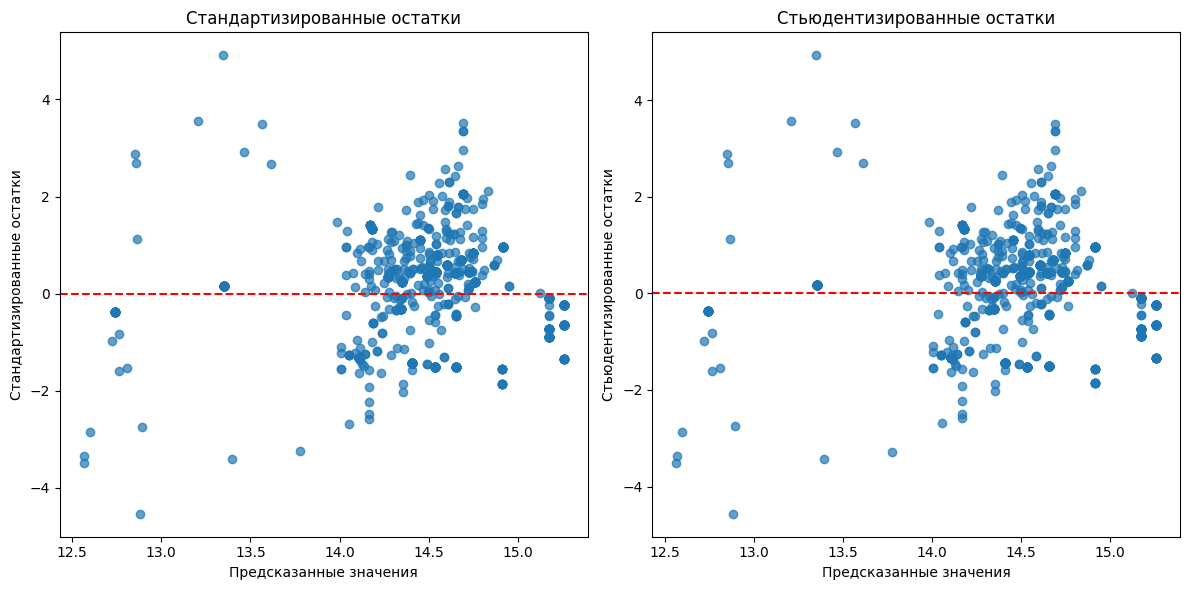

In [ ]:
fitted_values = model_linear_final.fittedvalues
residuals = model_linear_final.resid

standardized_residuals = residuals / np.std(residuals)

h_ii = model_linear_final.get_influence().hat_matrix_diag
studentized_residuals = residuals / (np.sqrt(model_linear_final.mse_resid * (1 - h_ii)))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(fitted_values, standardized_residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title('Стандартизированные остатки')
plt.xlabel('Предсказанные значения')
plt.ylabel('Стандартизированные остатки')

plt.subplot(1, 2, 2)
plt.scatter(fitted_values, studentized_residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title('Стьюдентизированные остатки')
plt.xlabel('Предсказанные значения')
plt.ylabel('Стьюдентизированные остатки')

plt.tight_layout()
plt.show()


### Тест бройша пагана

In [21]:
bp_test = sms.het_breuschpagan(model_linear_final.resid, model_linear_final.model.exog)

print('Breusch-Pagan Test:')
print(f'LM Statistic: {bp_test[0]:.4f}')
print(f'LM p-value: {bp_test[1]:.4f}')
print(f'F-Statistic: {bp_test[2]:.4f}')
print(f'F p-value: {bp_test[3]:.4f}')


Breusch-Pagan Test:
LM Statistic: 100.2656
LM p-value: 0.0000
F-Statistic: 11.9685
F p-value: 0.0000


### Тест Уайта

In [22]:
white_test = het_white(model_linear_final.resid, model_linear_final.model.exog)

labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
results = dict(zip(labels, white_test))

print('White Test Results:')
for key, value in results.items():
    print(f"{key}: {value:.4f}")


White Test Results:
Test Statistic: 703.2339
Test Statistic p-value: 0.0000
F-Statistic: 31.6866
F-Test p-value: 0.0000


### Робастные стандартные ошибки

In [33]:
model_robust = model_linear_final.get_robustcov_results(cov_type='HC3')
print(model_robust.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     1216.
Date:                Mon, 28 Apr 2025   Prob (F-statistic):               0.00
Time:                        20:30:09   Log-Likelihood:                 355.17
No. Observations:                1315   AIC:                            -690.3
Df Residuals:                    1305   BIC:                            -638.5
Df Model:                           9                                         
Covariance Type:                  HC3                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   11.3904 

### Проверка VIF

In [23]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_final.columns
vif_data["VIF"] = [variance_inflation_factor(X_final.values, i) for i in range(X_final.shape[1])]
print(vif_data)

                feature          VIF
0                 const  1684.901419
1               log_age     3.328943
2           brand_Geely     1.996271
3          is_restyling     1.830204
4  color_group_Холодные     1.148775
5           log_power_2     3.231328
6     city_group_Москва     1.423467
7      gearbox_механика     1.640035
8          drive_полный     2.553432
9   car_class_Crossover     1.974836


### Проверка полноранговости матрицы 


In [25]:
rank = np.linalg.matrix_rank(X_final)
print(f"Ранг матрицы: {rank}")

if rank == min(X_final.shape):
    print("Матрица полноранговая")
else:
    print("Матрица не является полноранговой")

Ранг матрицы: 10
Матрица полноранговая


### T-тест: нулевые мат ожидания ошибок

Если 
p
-значение выше 0.05 → нет оснований отвергать 
H
0
, математическое ожидание ошибок действительно ≈ 0.

In [26]:
t_stat, p_value = stats.ttest_1samp(model_linear_final.resid, popmean=0)
print(f't-статистика: {t_stat}, p-значение: {p_value}')

t-статистика: 1.7153103061119213e-12, p-значение: 0.9999999999986317
